# Notebook 4: Exploring Paleoclimate Data Assimilation

This notebook explores some of the equations used in paleoclimate data assimilation. It is not intended to be a full description of the methodology, but explores the heart of the method (here, the Ensemble Kalman Filter) in a highly simplified example.

This example uses code from the Last Millennium Reanalysis (LMR) project. You can find more information about that project at the following links:
 - Paper: https://cp.copernicus.org/articles/15/1251/2019/
 - Code: https://github.com/modons/LMR

## 1. Source of data: proxies and models

Paleoclimate data assimilation uses information from two sources:
 - **Proxies**: Data at discrete locations
 - **Model prior**: The "prior" is an ensemble of modeled climate states. It provides two things: 1) a first estimate of the range of possible climate states and 2) covariance information between every proxy location and all locations in every variable (and between different seasons and different variables, too!).

## 2. Intro to data assimilation at two locations

In real data assimilation, climate is reconstructed spatially on a latitude/longitude grid using data from a collection of proxies at various locations. For demonstration, we'll do a very simplied version which uses:
- One moment in time
- One proxy
- And we'll reconstruct two locations: One location near the proxy and one farther from it. (Imagine that these are two grid cells of a larger gridded model output)

All values in this example are already in units of degree C.

In [1]:
# Import python packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

## 3. Getting model data at two locations

Imagine that we're reconstructing annual mean temperature at New York City and Chicago using a proxy record near New York City. First, let's load our prior: ensembles of 100 annual mean temperatures at both locations. In real DA, you'll have to decide what makes sense as a prior (and it will be on a larger lat/lon grid). Here I've already gotten some model data.

The code below loads modeled temperature for the prior at the two locations, then creates two plots:
- Histograms of the prior at both locations
- A scatterplot showing the relationship of annual temperature between the two locations.

Make sure to read through comments in the code to understand what's going on.

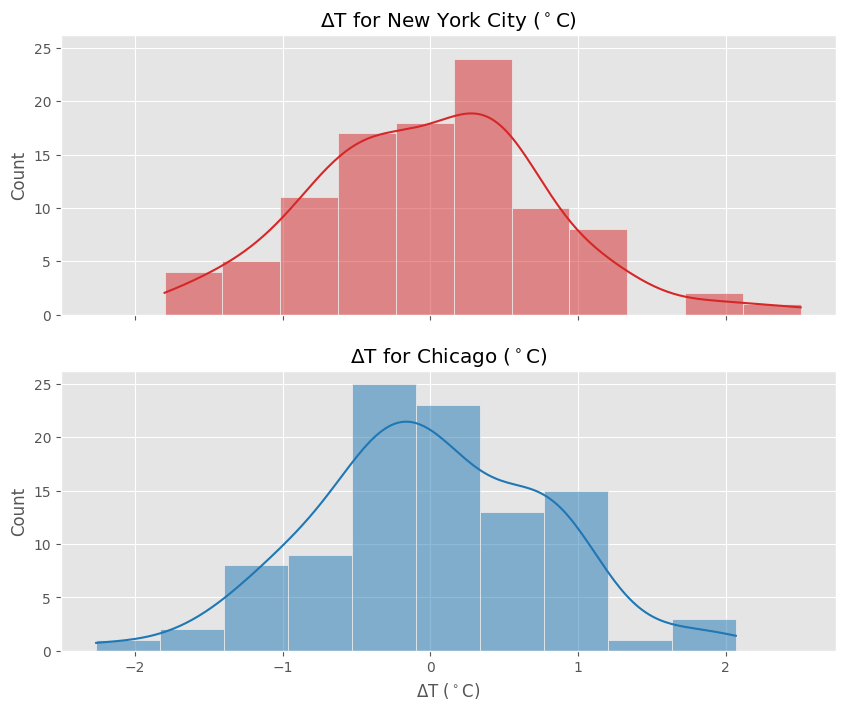

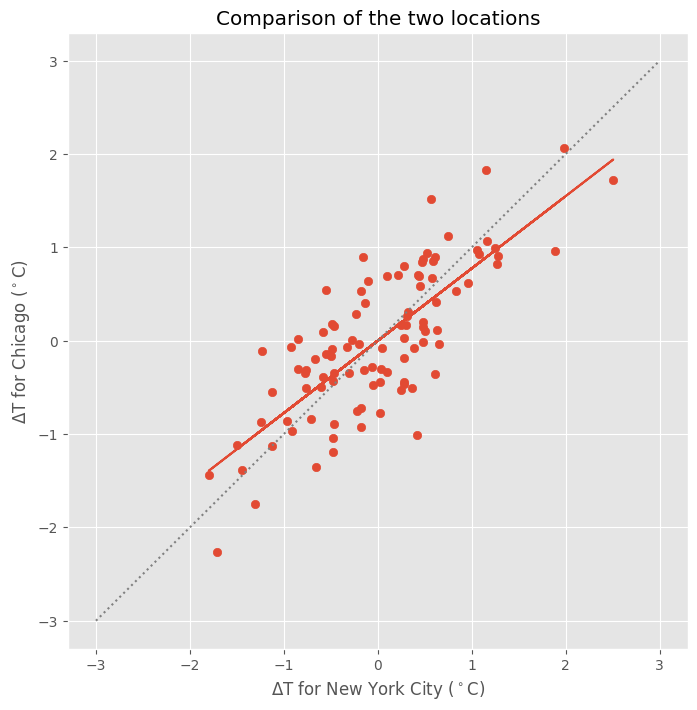

Slope: 0.774589408012836
R-squared: 0.6023317636594651
Prior shape: (2, 100)


In [ ]:
# Load the prior data for each location (each location has 100 prior ensemble members)
prior_NewYork = np.array([10.60791  ,  9.704529 , 11.793335 , 11.917023 , 11.989929 , 10.364166 , 11.48819  ,  9.533173 , 11.2178955, 12.817291 ,
                          11.301483 , 10.935547 , 11.39917  , 10.120361 , 11.15686  , 11.358124 , 11.459534 , 10.069275 ,  9.390045 , 11.440094 ,
                          12.718323 , 10.731964 , 10.360291 ,  9.036102 ,  9.125061 , 10.279083 ,  9.985748 , 10.3367   , 10.074066 ,  9.871826 ,
                          10.931793 ,  9.909882 , 11.318909 , 10.177765 , 10.785736 , 12.119385 , 11.896088 , 10.639008 , 11.083588 , 10.248383 ,
                          11.142273 , 10.856049 , 10.36377  , 10.281769 , 11.111847 , 11.113953 , 11.320282 , 11.443909 , 11.249756 , 11.077454 ,
                          10.688873 , 11.134125 , 10.253845 , 11.119568 , 10.063477 , 11.112762 , 10.34491  ,  9.33667  , 11.415527 , 11.420929 ,
                          10.371002 , 10.704559 , 10.662018 , 11.261322 , 10.673157 , 10.351288 , 10.609772 ,  9.707123 , 11.118652 , 11.315979 ,
                          10.170746 , 10.234375 , 10.652588 , 10.556946 , 11.995605 , 11.275391 ,  9.593231 , 11.584076 , 12.083771 , 10.877228 ,
                           9.59903  ,  9.918732 , 10.86496  , 10.769287 , 10.657013 , 10.508362 ,  9.990997 , 11.32016  , 10.859253 , 11.67215  ,
                          11.194763 , 10.36908  , 12.108856 , 13.3420105, 11.340393 , 11.465668 , 10.525482 , 11.280762 , 10.365509 , 11.055328 ])

prior_Chicago = np.array([ 9.642731 ,  8.801697 ,  9.973419 , 10.282074 , 11.185272 , 8.309692 ,  9.321686 ,  7.6092834,  9.2725525, 11.421753 ,
                          10.192474 ,  9.016327 , 10.870575 ,  8.513611 ,  9.665283 , 10.296753 ,  9.769104 ,  9.035553 ,  7.964386 ,  8.993927 ,
                          10.319366 ,  9.993774 ,  8.15921  ,  7.910431 ,  7.091522 ,  9.213867 ,  9.373962 ,  9.188873 ,  8.847443 ,  8.49881  ,
                          10.042664 ,  9.291901 , 10.2308655,  7.999115 ,  8.875183 , 10.262238 , 10.330353 ,  9.320862 ,  8.827759 ,  8.966309 ,
                           9.61438  ,  8.576324 ,  8.923218 ,  9.896545 ,  8.890839 , 10.156342 ,  9.504395 , 10.256317 ,  8.346039 ,  9.52182  ,
                           9.0364685,  9.523468 ,  9.442627 ,  9.388519 ,  9.005096 ,  9.169067 ,  9.264374 ,  8.236023 , 10.021759 , 10.206177 ,
                           9.51416  ,  9.754181 ,  8.6302185, 10.059357 , 10.25412  ,  9.529175 ,  8.597992 ,  8.225159 ,  8.916748 ,  9.558563 ,
                           9.160339 ,  8.855377 ,  9.883575 ,  9.366913 , 10.427338 , 10.044067 ,  8.487915 , 10.477325 , 10.346558 ,  9.279022 ,
                           9.242828 ,  8.38797  ,  9.056244 ,  9.074066 ,  8.432495 ,  9.292114 ,  9.053864 ,  9.343964 ,  8.914246 ,  9.891602 ,
                           8.851715 ,  8.458069 , 10.171112 , 11.07782  ,  9.461639 ,  9.470123 ,  9.01062  ,  9.936218 ,  9.009247 , 10.061188 ])

# Sometimes, priors are designed to have a mean of 0, so we'll do that here.
prior_NewYork = prior_NewYork - np.mean(prior_NewYork)
prior_Chicago = prior_Chicago - np.mean(prior_Chicago)

# Make histograms of both locations
f, ax = plt.subplots(2,1,figsize=(10,8),sharex=True,sharey=True)
ax = ax.ravel()
sns.histplot(prior_NewYork,kde=True,color='tab:red', ax=ax[0])
sns.histplot(prior_Chicago,kde=True,color='tab:blue',ax=ax[1])
ax[0].set_title('$\Delta$T for New York City ($^\circ$C)')
ax[1].set_title('$\Delta$T for Chicago ($^\circ$C)')
ax[1].set_xlabel('$\Delta$T ($^\circ$C)')
plt.show()

# Calculate the regression between the two locations, just to see how these two locations compare
slope,intercept,rvalue,_,_ = stats.linregress(prior_NewYork,prior_Chicago)

# Make a scatterplot between the two locations, along with a linear regression line
plt.figure(figsize=(8,8))
plt.scatter(prior_NewYork,prior_Chicago)
plt.plot(prior_NewYork,(slope*prior_NewYork)+intercept)
plt.plot([-3,3],[-3,3],'gray',linestyle=':')
plt.xlabel('$\Delta$T for New York City ($^\circ$C)')
plt.ylabel('$\Delta$T for Chicago ($^\circ$C)')
plt.title('Comparison of the two locations')
plt.show()

# Print the slope and R-squared values between the two locations, for reference
print('Slope:',slope)
print('R-squared:',np.square(rvalue))

# Put the prior into the right shape for the assimilation later
Xb = np.stack((prior_NewYork,prior_Chicago),axis=0)  # Combine the data into a single array
print('Prior shape:',Xb.shape)

Our prior defines the inital ranges of values at each location and the relationship between the two locations. For the two locations above (New York City and Chicago), annual mean temperature is highly related. So, if a proxy says that it's a warm year in New York, it's probably a warm year in Chicago too. Furthermore, we can see that the slope is 0.77, so temperature anomalies in Chicago are typically 77% as large as those in New York (in this sample of 100 years).

Covariances between different locations are at the heart of data assimiltion. They allow us to infer climate at distant locations based on known data.

For paleoclimate data assimilation, we need several things, each of which we've given the following variable names in the code:
 - The prior: **Xb**, defined above
 - Proxy data: **obvalue** and **ob_err**, defined later
 - Model-based estimates of the proxy data: **Ye**. (Note: this is often called **H(Xb)**)

Where does "Ye" come from? Since all of our data is already in units of degrees C and our proxy is an annual mean, the model-based proxy estimate will be the same as the prior in New York City. Keep in mind that proxy system models (PSMs) are often used in real DA, adding a bit more complexity.

Let's set **Ye** below.



In [ ]:
# Initial estimates of the value at the proxy location.
Ye = prior_NewYork

When we do the data assimilation, the model-based estimate of the proxy ("Ye") will be compared to the proxy data to see if our prior is too hot or too cold.

## 4. The Ensemble square-root filter

Here, I've copied the ensemble square-root filter from the Last Millennium Reanalysis (LMR) code, which is explored in Eq. 4a,b of Tardif et al., 2019, "Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling". Starting with the model prior, the code first updates the ensemble mean then updates the ensemble spread.

I've added some extra code at the end to plot a figure that compares the prior and posterior. Other filters can be used here, but this one is relatively simple to understand. This is the heart of data assimilation. Let's go ahead and execute this code cell and we'll use it later on.

In [ ]:
def enkf_update_array(Xb, obvalue, Ye, ob_err, loc=None, inflate=None):
    """
    Function to do the ensemble square-root filter (EnSRF) update
    (ref: Whitaker and Hamill, Mon. Wea. Rev., 2002)

    Originator: G. J. Hakim, with code borrowed from L. Madaus
                Dept. Atmos. Sciences, Univ. of Washington

    Revisions:

    1 September 2017:
                    - changed varye = np.var(Ye) to varye = np.var(Ye,ddof=1)
                    for an unbiased calculation of the variance.
                    (G. Hakim - U. Washington)

    -----------------------------------------------------------------
     Inputs:
          Xb: background ensemble estimates of state (Nx x Nens)
     obvalue: proxy value
          Ye: background ensemble estimate of the proxy (Nens x 1)
      ob_err: proxy error variance
         loc: localization vector (Nx x 1) [optional]
     inflate: scalar inflation factor [optional]
    """

    # Get ensemble size from passed array: Xb has dims [state vect.,ens. members]
    Nens = Xb.shape[1]

    # ensemble mean background and perturbations
    xbm = np.mean(Xb,axis=1)
    Xbp = np.subtract(Xb,xbm[:,None])  # "None" means replicate in this dimension

    # ensemble mean and variance of the background estimate of the proxy
    mye   = np.mean(Ye)
    varye = np.var(Ye,ddof=1)

    # lowercase ye has ensemble-mean removed
    ye = np.subtract(Ye, mye)

    # innovation
    try:
        innov = obvalue - mye
    except:
        print('innovation error. obvalue = ' + str(obvalue) + ' mye = ' + str(mye))
        print('returning Xb unchanged...')
        return Xb

    # innovation variance (denominator of serial Kalman gain)
    kdenom = (varye + ob_err)

    # numerator of serial Kalman gain (cov(x,Hx))
    kcov = np.dot(Xbp,np.transpose(ye)) / (Nens-1)

    # Option to inflate the covariances by a certain factor
    #if inflate is not None:
    #    kcov = inflate * kcov # This implementation is not correct. To be revised later.

    # Option to localize the gain
    if loc is not None:
        kcov = np.multiply(kcov,loc)

    # Kalman gain
    kmat = np.divide(kcov, kdenom)

    # update ensemble mean
    xam = xbm + np.multiply(kmat,innov)

    # update the ensemble members using the square-root approach
    beta = 1./(1. + np.sqrt(ob_err/(varye+ob_err)))
    kmat = np.multiply(beta,kmat)
    ye   = np.array(ye)[np.newaxis]
    kmat = np.array(kmat)[np.newaxis]
    Xap  = Xbp - np.dot(kmat.T, ye)

    # full state
    Xa = np.add(xam[:,None], Xap)

    # if masked array, making sure that fill_value = nan in the new array
    if np.ma.isMaskedArray(Xa): np.ma.set_fill_value(Xa, np.nan)

    # === START OF EXTRA CODE ===

    ### FIGURE
    # Make a figure showing the prior vs the posterior
    f, ax = plt.subplots(2,1,figsize=(10,8),sharex=True,sharey=True)
    ax = ax.ravel()

    sns.histplot(Xb[0,:],kde=True,color='tab:red', ax=ax[0],label='Prior values, mean='+str('{:.2f}'.format(np.mean(Xb[0,:]))))
    sns.histplot(Xa[0,:],kde=True,color='tab:blue',ax=ax[0],label='Posterior values, mean='+str('{:.2f}'.format(np.mean(Xa[0,:]))))
    ax[0].axvline(obvalue,color='k',label='Proxy value')
    ax[0].legend()
    ax[0].set_title('Prior and posterior temperature at proxy location (New York, $^\circ$C)')

    sns.histplot(Xb[1,:],kde=True,color='tab:red', ax=ax[1],label='Prior values, mean='+str('{:.2f}'.format(np.mean(Xb[1,:]))))
    sns.histplot(Xa[1,:],kde=True,color='tab:blue',ax=ax[1],label='Posterior values, mean='+str('{:.2f}'.format(np.mean(Xa[1,:]))))
    ax[1].legend()
    ax[1].set_title('Prior and posterior temperature at remote location (Chicago, $^\circ$C)')

    plt.show()

    # === END OF EXTRA CODE ===

    # Return the full state
    return Xa

## 5. Data assimilation examples

Normally, proxy values come from actual data. Here, we'll just make up some data. We need two values: the proxy anomaly (**obvalue**) and uncertainty (**ob_err**). Let's do two examples. In both cases, the proxy temperature anomaly is 1 degree C, but we'll change the amount of uncertainty.

### Example 1: Assimilating a proxy

First, to get a sense of how the method works, let's assimilate a proxy for the current time step. In real DA, you can loop through every proxy, progressively updating the prior (or assimilate all proxies at once using linear algebra), but here we're only using 1 proxy, so it will assimilate the proxy and make a figure to show how the prior was updated.

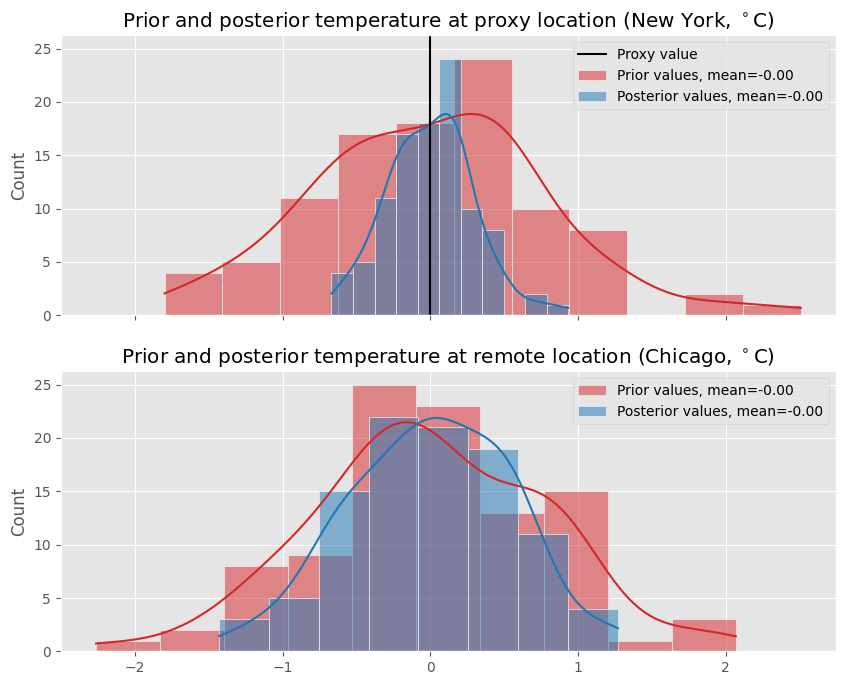

In [ ]:
# Proxy data
obvalue = 0  # Proxy data for the year of interest
ob_err  = .1  # Mean squared error (i.e. uncertainty) for the proxy value

# Do the assimilation
Xa = enkf_update_array(Xb,obvalue,Ye,ob_err)

In the results above, the reconstructed range of temperatures at New York has been made warmer to agree better with the proxy. Temperatures in Chicago have also been made warmer, since annual mean temperatures in Chicago is positively correlated with those in New York (see the scatterplot farther up this page). Note that Chicago hasn't been warmed by as much as New York, since the slope between them is < 1.

So, these results seem reasonable. To better understand what's going on, let's try a different example: a proxy with a smaller amount of error.

### Example 2: A proxy with little error

**Try this:** In this example, set the uncertainty in the code above to 0.1. Before you run the code, make some predictions. Two questions:
1. For New York, do you expect the reconstructed temperature to be warmer or colder than the previous example? Do you expect the range of uncertainties to get narrower or wider?
2. What about the mean and spread for Chicago?

To make predictions, refer to the scatterplot and slope earlier in the notebook. Once you've made some predictions and set ob_err to 0.1, run the code again.

**Try this:** Continue to experiment by changing the values of "obvalue" and "ob_err". If you set "ob_err" to 10, what happens? Are the results consistent with what you expect?

## 6. Take-aways

From these examples, we can make several observations:
 - At the proxy location (upper panel), assimilation brings the temperature estimates in better alignment with the data. When proxy uncertainty is small, the reconstructed temperature gets closer to the proxy value and the uncertainty is reduced.
 - The remote location gets updated as well, based on how it covaries with the original location.

Does this make sense to you? Chat with the rest of your group about these results.

## 7. Looking ahead

This notebook only uses two locations: the proxy location and a single remote location. In a more realistic case, there are many locations on a lat/lon grid. There are also many proxy records, which can be assimilated sequentially or all at once. Sometimes covariance localization is used so that proxies can only update nearby locations. The proxy data will not all agree perfectly, so they all "tug" the reconstruction in different ways. The final reconstruction, therefore, is a compromise between the prior and all available proxy data.

If you want to see how this code works in a full data assimilation experiment of the last 2000 years, see the links to the LMR project at the top of this page.

In the next notebook, we'll run a real data assimilation experiment.